**Gathering the Data**

I imported the following 3 data for gathering the data.<br>
・"twitter-archive-enhanced.csv"<br>
・tweepy.API data as "tweet_json.txt"<br>
・"image-predictions.tsv"<br>

In [2]:
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import requests
import json

In [3]:
tae_data = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
from tweepy import OAuthHandler
from timeit import default_timer as timer

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = tae_data.tweet_id.values
len(tweet_ids)


2356

In [ ]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [5]:
df_list = []
with open('tweet-json.txt') as file:
    for line in file:
        data = json.loads(line)
        keys = data.keys()
        user = data.get('user')
        id_str = data.get('id_str')
        retweet_count = data.get('retweet_count')
        favorite_count = data.get('favorite_count')
        df_list.append({'id_str': id_str,'retweet_count': retweet_count,'favorite_count': favorite_count})

In [6]:
tweet_count = pd.DataFrame(df_list, columns = ['id_str', 'retweet_count', 'favorite_count'])

In [7]:
folder_name = 'image_pred'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [8]:
image_pred = pd.read_csv('image-predictions.tsv', sep='\t')

**Assessing the Data**

I checked the data condition of each imported data as follows.

In [22]:
tae_data.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [13]:
tae_data.text.sample(10)

1016    PUPDATE: can't see any. Even if I could, I cou...
44      This is Noah. He can't believe someone made th...
240     This is Barney. He's an elder doggo. Hitches a...
727     This is Sampson. He just graduated. Ready to b...
1180    Say hello to Lucy and Sophie. They think they'...
815     RT @katieornah: @dog_rates learning a lot at c...
1375    This is Bilbo. He's not emotionally prepared t...
2048    Say hello to Hammond. He's just a wee lil pup....
2263    This is Kial. Kial is either wearing a cape, w...
1026    This is Gustav. He has claimed that plant. It ...
Name: text, dtype: object

In [18]:
tweet_count.head()

,id_str,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [19]:
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
tae_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [32]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Based on the above understanding of data conditions, the following eight quality issues have been fixed.<br>
①Delete rows / columns that contain at least one missing value on the twitter-archive-enhanced.<br>
②Change the column name from "floofer" to "floof" on the twitter-archive-enhanced.<br>
③Change the data type of the coiumn "tweet_id" from "int64" to "object" on the twitter-archive-enhanced.<br>
④Change the data type of the coiumn "timestamp" from "object" to "datatime" on the twitter-archive-enhanced.<br>
⑤Change the coiumn "text" in terms of deleting amp, removing line breaks, deleting URL and deleting characters at both ends on the twitter-archive-enhanced.<br>
⑥Change the coiumn "name" from "a/an/the" to "None" on the twitter-archive-enhanced.<br>
⑦Change the dog type in columns p1, p2 and p3 to lowercase on the image-predictions.<br>
⑧Change the data type of the coiumn "tweet_id" from "int64" to "object" on the tweet-json.<br>

In [9]:
tae_data_clean = tae_data.copy()
image_clean = image_pred.copy()
tweet_clean = tweet_count.copy()

①Delete rows / columns that contain at least one missing value on the twitter-archive-enhanced.

In [10]:
tae_data_clean.dropna(axis='columns',how='any', inplace=True)

②Change the column name from "floofer" to "floof" on the twitter-archive-enhanced.

In [11]:
tae_data_clean.rename(columns={"floofer": "floof"}, inplace=True)

③Change the data type of the coiumn "tweet_id" from "int64" to "object" on the twitter-archive-enhanced.

In [12]:
tae_data_clean['tweet_id'] = tae_data_clean['tweet_id'].astype('str')

④Change the data type of the coiumn "timestamp" from "object" to "datatime" on the twitter-archive-enhanced.

In [13]:
tae_data_clean['timestamp'] = pd.to_datetime(tae_data_clean['timestamp'])

⑤Change the coiumn "text" in terms of deleting amp, removing line breaks, deleting URL and deleting characters at both ends on the twitter-archive-enhanced.

In [14]:
tae_data_clean['text'] = tae_data_clean.text.str.replace("&amp;", "&")
tae_data_clean['text'] = tae_data_clean.text.str.replace("\n", " ")
tae_data_clean['text'] = tae_data_clean.text.str.replace(r"http\S+", "")
tae_data_clean['text'] = tae_data_clean.text.str.strip()

⑥Change the coiumn "name" from "a/an/the" to "None" on the twitter-archive-enhanced.

In [17]:
aan_list = list(tae_data_clean.query('name == "a" or name == "an" or name == "the"').index).copy()

In [18]:
for i in aan_list:
    tae_data_clean.name[i] = "None"

In [18]:
tae_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floof                 2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 202.5+ KB


⑦Change the dog type in columns p1, p2 and p3 to lowercase on the image-predictions.

In [19]:
image_clean['p1'] = image_clean['p1'].str.lower()
image_clean['p2'] = image_clean['p2'].str.lower()
image_clean['p3'] = image_clean['p3'].str.lower()

⑧Change the data type of the coiumn "tweet_id" from "int64" to "object" on the tweet-json.

In [20]:
image_clean['tweet_id'] = image_clean['tweet_id'].astype('str')

In [25]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


Combine the "tae_data_clean" and the "tweet_clean".

In [21]:
merge_tae_tweet = tae_data_clean.join(tweet_clean.set_index('id_str'), on='tweet_id')

In [22]:
merge_tae_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floof                 2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
retweet_count         2354 non-null float64
favorite_count        2354 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 239.4+ KB


Combine the "merge_tae_tweet" and the "image_clean".

In [22]:
merge_tae_tweet_image = merge_tae_tweet.join(image_clean.set_index('tweet_id'), on='tweet_id')

In [24]:
merge_tae_tweet_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floof                 2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
retweet_count         2354 non-null float64
favorite_count        2354 non-null float64
jpg_url               2075 non-null object
img_num               2075 non-null float64
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null object
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                

Removing the missing rows from the merged tables

In [23]:
merge_tae_tweet_image_copy = merge_tae_tweet_image.copy()

In [24]:
drop_index = merge_tae_tweet_image_copy[pd.isnull(merge_tae_tweet_image_copy['jpg_url'])].index
drop_index2 = merge_tae_tweet_image_copy[pd.isnull(merge_tae_tweet_image_copy['retweet_count'])].index

In [25]:
merge_tae_tweet_image_copy.drop(index=drop_index, inplace=True)
merge_tae_tweet_image_copy.drop(index=drop_index2, inplace=True)

Add column "Section" with columns "doggo","floof","pupper" and "puppo".<br>

In [26]:
merge_tae_tweet_image_copy.loc[(merge_tae_tweet_image_copy['doggo'] == 'doggo') & (merge_tae_tweet_image_copy['floof'] == 'None') & (merge_tae_tweet_image_copy['pupper'] == 'None') & (merge_tae_tweet_image_copy['puppo'] == 'None'), 'Section'] = 'doggo'
merge_tae_tweet_image_copy.loc[(merge_tae_tweet_image_copy['doggo'] == 'None') & (merge_tae_tweet_image_copy['floof'] == 'floofer') & (merge_tae_tweet_image_copy['pupper'] == 'None') & (merge_tae_tweet_image_copy['puppo'] == 'None'), 'Section'] = 'floof'
merge_tae_tweet_image_copy.loc[(merge_tae_tweet_image_copy['doggo'] == 'None') & (merge_tae_tweet_image_copy['floof'] == 'None') & (merge_tae_tweet_image_copy['pupper'] == 'pupper') & (merge_tae_tweet_image_copy['puppo'] == 'None'), 'Section'] = 'pupper'
merge_tae_tweet_image_copy.loc[(merge_tae_tweet_image_copy['doggo'] == 'None') & (merge_tae_tweet_image_copy['floof'] == 'None') & (merge_tae_tweet_image_copy['pupper'] == 'None') & (merge_tae_tweet_image_copy['puppo'] == 'puppo'), 'Section'] = 'puppo'

In [27]:
merge_tae_tweet_image_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              2073 non-null object
timestamp             2073 non-null datetime64[ns]
source                2073 non-null object
text                  2073 non-null object
rating_numerator      2073 non-null int64
rating_denominator    2073 non-null int64
name                  2073 non-null object
doggo                 2073 non-null object
floof                 2073 non-null object
pupper                2073 non-null object
puppo                 2073 non-null object
retweet_count         2073 non-null float64
favorite_count        2073 non-null float64
jpg_url               2073 non-null object
img_num               2073 non-null float64
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null object
p2                    2073 non-null object
p2_conf               2073 non-null float64
p2_dog                

Create csv data as "clean_data.csv".

In [28]:
merge_tae_tweet_image_copy.to_csv(path_or_buf='clean_data.csv', index=False)

The following two points were the restrictions in data analysis.<br>
1.In the three data joins, if "Tweet_id" did not exist, it was excluded.<br>
2.In the adding column "Section", if two or more were applicable, set to "None".<br>

**Data analysis**

Question1：What are the top5 dog names?<br>
Answer1："Charlie","Tucker","Cooper","Lucy","Penny" according to the below table.

In [29]:
a = merge_tae_tweet_image_copy.groupby('name').count()

In [30]:
a.sort_values(by='tweet_id', ascending=False).head(6)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,doggo,floof,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,Section
name,,,,,,,,,,,,,,,,,,,,,
None,646,646,646,646,646,646,646,646,646,646,...,646,646,646,646,646,646,646,646,646,122
Charlie,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,1
Tucker,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0
Cooper,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,3
Lucy,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,1
Penny,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0


Question2：What kind of dogs have the most retweet_count and favorite_count?<br>
Answer2：The doggo has the most retweet_count and the pupper has the most favorite_count.

In [31]:
merge_tae_tweet_image_copy.groupby(by=['Section']).sum()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
Section,,,,,,,,
doggo,802,670,529404.0,1219452.0,88.0,38.987961,10.691506,4.069905
floof,84,70,34781.0,92442.0,8.0,4.264427,1.087233,0.335976
pupper,2258,2100,518324.0,1461141.0,263.0,126.626646,27.560504,11.988803
puppo,276,230,147923.0,474806.0,33.0,16.590904,3.226065,1.000438


Question3：What is the most accurate dog in the algorithm's # 1 prediction for the images in the tweet?<br>
Answer3:In the case of golden_retriever, it predicts with an average of 72% accuracy in 150 judgments, and it is judged to be the most accurate.

In [120]:
merge_tae_tweet_image_copy2 = merge_tae_tweet_image_copy[['tweet_id', 'p1', 'p1_conf', 'p1_dog']]

Extract the data where "p1_dog" is "True".

In [121]:
data_p1 = merge_tae_tweet_image_copy2.query('p1_dog == True')

Extract the top 20 of the average value.

In [139]:
p1_conf_mean = data_p1.groupby(by=['p1']).mean().sort_values(by='p1_conf',ascending=False)

In [140]:
p1_conf_mean_top20 = p1_conf_mean[0:20]

In [141]:
print(p1_conf_mean_top20)

                              p1_conf
p1                                   
komondor                     0.972531
clumber                      0.946718
brittany_spaniel             0.874545
keeshond                     0.844431
bull_mastiff                 0.815618
bernese_mountain_dog         0.801816
french_bulldog               0.770627
pug                          0.757663
pomeranian                   0.743606
samoyed                      0.741036
german_short-haired_pointer  0.732425
doberman                     0.724541
golden_retriever             0.723555
german_shepherd              0.719445
pembroke                     0.717223
black-and-tan_coonhound      0.692000
saint_bernard                0.686821
boxer                        0.682523
leonberg                     0.681635
blenheim_spaniel             0.668075


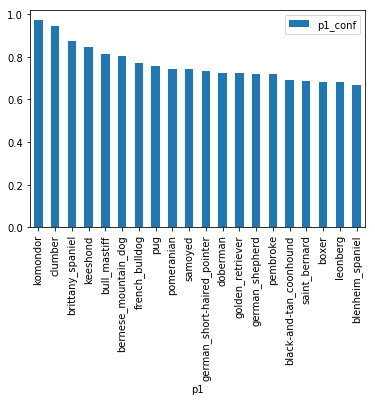

In [136]:
p1_conf_mean_top20.plot.bar()

Extract the top 20 of "tweet_id" counts.

In [142]:
p1_conf_count = data_p1.groupby(by=['p1']).count().sort_values(by='tweet_id',ascending=False)

In [143]:
p1_conf_count_top20 = p1_conf_count[0:20]

In [144]:
print(p1_conf_count_top20)

                           tweet_id  p1_conf  p1_dog
p1                                                  
golden_retriever                150      150     150
labrador_retriever              100      100     100
pembroke                         88       88      88
chihuahua                        83       83      83
pug                              57       57      57
chow                             44       44      44
samoyed                          43       43      43
toy_poodle                       39       39      39
pomeranian                       38       38      38
malamute                         30       30      30
cocker_spaniel                   30       30      30
french_bulldog                   26       26      26
miniature_pinscher               23       23      23
chesapeake_bay_retriever         23       23      23
german_shepherd                  20       20      20
siberian_husky                   20       20      20
staffordshire_bullterrier        20       20  

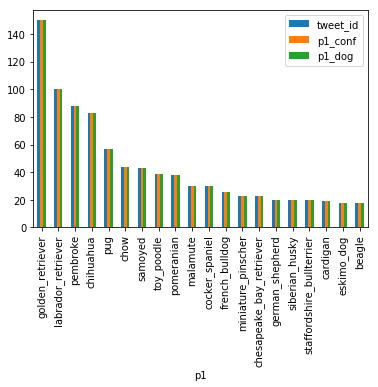

In [137]:
p1_conf_count_top20.plot.bar()

Combine the "top 20 of the average value" and the "the top 20 of tweet_id counts".

In [149]:
c = pd.merge(p1_conf_mean_top20, p1_conf_count_top20, on='p1')
print(c)

                  p1_conf_x  tweet_id  p1_conf_y  p1_dog
p1                                                      
french_bulldog     0.770627        26         26      26
pug                0.757663        57         57      57
pomeranian         0.743606        38         38      38
samoyed            0.741036        43         43      43
golden_retriever   0.723555       150        150     150
german_shepherd    0.719445        20         20      20
pembroke           0.717223        88         88      88


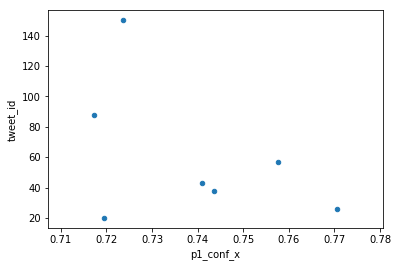

In [150]:
c.plot.scatter(x='p1_conf_x', y='tweet_id')